# Tesla's Stock Prediction 

--------------------------------------
The project is divided into two parts:

1. Sentiment analysis on News Headlines(Tesla)
2. Stock Price Predictions 

**Objective** : The project is aimed to recognize the stock price **rise** and **fall** through sentiment analysis of the news headlines. Then predicting the stock prices.

# Importing Libraries

-------------------------------------------------

- **Pandas** : For data analysis and data manipulation
- **Matplotlib and Seaborn** : For visualizing the results got from data analysis and machine learning models
- **Numpy** : For working with arrays and performing mathematical operations
- **NLTK** : For handling and preprocessing textual data
- **warnings** : For ignoring unnecessary warnings due to differen versions of the modules
- **VaderSentiment** : For getting the sentiment scores for textual data
- **TextBlob** : For using in feature engineering to get more features like subjectivity and polarity
- **Sklearn** : For performing machine learning on the dataset

In [ ]:
import pandas as pd 
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import warnings
import math
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
! pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from mlxtend.plotting import plot_confusion_matrix
import string

     |████████████████████████████████| 125 kB 5.4 MB/s 


# Loading the data

**Tesla Articles.xlsx** : This dataset has Tesla's news headlines of 2020. It has 95 rows and 2 columns (Date, Articles)

**TSLA.csv** : This dataset has the stock price from 2016 till now. It has 7 columns date, open, high, low, close, adj close and volume.

In [ ]:
# Reading the excel file and changing the name of the columns 
articles = pd.read_excel('/content/Tesla Articles.xls')
articles.columns = ['Date','Articles']

# Removing the '\n' from the articles data and replacing it with empty string
articles['Articles'] = articles['Articles'].apply(lambda x: x.replace("\n", ""))

stock = pd.read_csv('/content/TSLA.csv') # Reading the csv file for stock prices
stock['Date'] = pd.to_datetime(stock['Date']) # Converting the date column to datetime

## 1. Sentiment Analysis on News Headlines

### Cleaning the data and Text Preprocessing  

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
df = articles
# Creating function to change the whole text to lowercase
def lower(words):
    return words.lower()
# applying the function on the Articles column
df['Articles']=df['Articles'].apply(lambda x:lower(x))

# Creating function to remove the punctuation if present in the articles column
def remove_punctuation(words):
    table=str.maketrans('','',string.punctuation)
    return words.translate(table)
df['Articles']=df['Articles'].apply(lambda x: remove_punctuation(x))

# Tokenizing the articles data
df['Articles']=df['Articles'].apply(lambda x:word_tokenize(x))

# Creating function that will go through every tokens of the articles and then changing the words 
# to its original form
def lemmatizing(words):
    lemmatizer =WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]
df['Articles']=df['Articles'].apply(lambda x: lemmatizing(x))

# Joining the preprocessed text as a sentence
def final_text(words):
     return ' '.join(words)
df['Articles']=df['Articles'].apply(lambda x:final_text(x))

# Removing the unrelevat things from the data
df['Articles'] = df['Articles'].apply(lambda x: x.replace("‘", ""))
df['Articles'] = df['Articles'].apply(lambda x: x.replace("’", ""))
df['Articles'] = df['Articles'].apply(lambda x: x.replace("“", ""))
df['Articles'] = df['Articles'].apply(lambda x: x.replace("”", ""))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Feature Engineering

Creating more features from the textual data for training model.

In [ ]:
def getSubjectivity(text): # function to get subjectivity scores
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text): # function to get polarity scores
    return TextBlob(text).sentiment.polarity

def getSentimentScore(text): #function to get sentiment scores
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)

# applying the functions getSubjectivity and getPolarity on the articles data
# creating new feature for subjectivity and polarity
df['Subjectivity'] = df['Articles'].apply(lambda x: getSubjectivity(x))
df['Polarity'] = df['Articles'].apply(lambda x: getPolarity(x))

# Creating four different list to store the sentiment scores
compound = []
positive = []
negative = []
neutral = []
for i in range(0, len(df)):
    SIA = getSentimentScore(df['Articles'][i])
    compound.append(SIA['compound'])
    positive.append(SIA['pos'])
    negative.append(SIA['neg'])
    neutral.append(SIA['neu'])
    
# Creating new features and saving the respective lists in them
df['Compound'] = compound
df['Positive'] = positive
df['Negative'] = negative
df['Neutral'] = neutral

# Creating label from compond features
label = []
for i in df['Compound']:
    if i>0:
        label.append(1)
    else:
        label.append(0)
df['Label'] = label

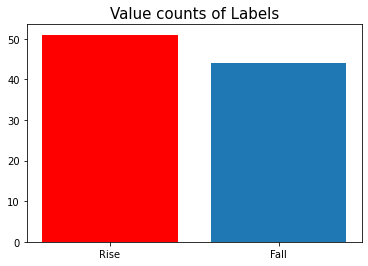

In [ ]:
# Plotting bar graph to see if the dataset is balanced or not
plt.title('Value counts of Labels', fontsize = 15)
bar = plt.bar(['Rise','Fall'],df['Label'].value_counts())
bar[0].set_color('r')

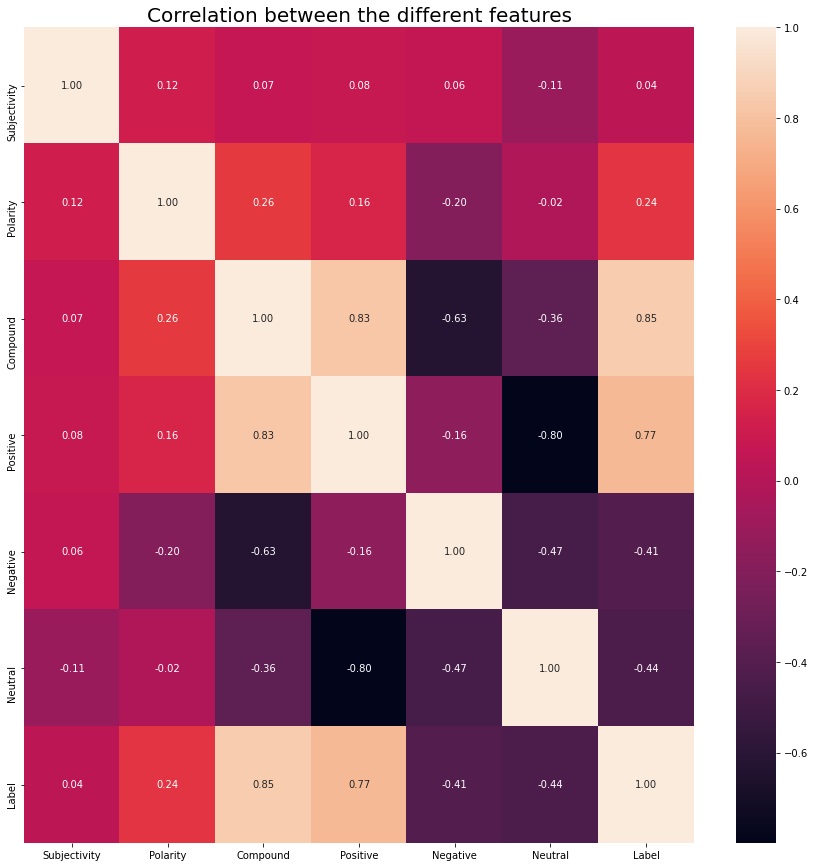

In [ ]:
f,ax=plt.subplots(figsize=(15,15))
plt.title('Correlation between the different features', fontsize = 20)
sns.heatmap(df.corr(),annot=True,linecolor="blue",fmt=".2f",ax=ax)
plt.show()

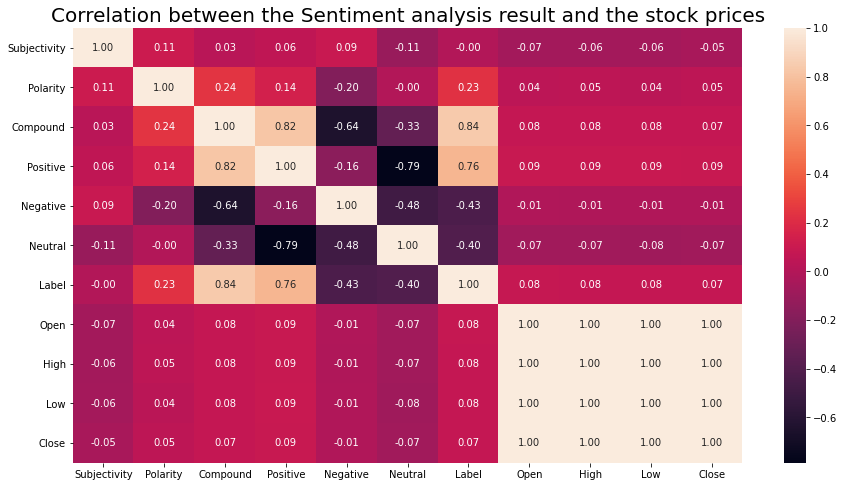

In [ ]:
merge = articles.merge(stock, on = 'Date', how = 'inner', left_index = False)
f,ax=plt.subplots(figsize=(15,8))
plt.title('Correlation between the Sentiment analysis result and the stock prices', fontsize = 20)
sns.heatmap(merge.drop(['Date','Articles','Volume','Adj Close'], axis = 1).corr(),annot=True,linecolor="blue",fmt=".2f", ax=ax)
plt.show()


### Splitting the dataset

In [ ]:
# splitting the dataset in train and test data using 30 rows as test data and rest as training data
train_df = df[['Articles','Subjectivity','Polarity','Positive','Negative','Neutral','Label']][:-30]
test_df = df[['Articles','Subjectivity','Polarity','Positive','Negative','Neutral','Label']][-30:] 

### Feature Extraction (TFIDF Vectorizer)
The words need to be encoded as integers or floating point values for use as input to a machine learning algorithm, called feature extraction (or vectorization). TF IDF Vectorizer of sklearn library is used for this.

In [ ]:
vect=TfidfVectorizer(min_df=2
                      ,analyzer="word",  ngram_range=(1,4) 
                           ).fit(train_df['Articles'])
x_train_vect=vect.fit_transform(train_df['Articles'])
# Combining textual as well as numerical features in training set
X = np.hstack((x_train_vect.todense(), train_df.drop(['Label','Articles'], axis = 1)))

## Training Machine learning models

In [ ]:
model1 = DecisionTreeClassifier()
model1.fit(X,train_df['Label'])
# Prediction on the test data
predictions=model1.predict(np.hstack((vect.transform(test_df['Articles']).todense(),
                                      test_df.drop(['Label','Articles'], axis = 1))))
accuracy_dtc = round(accuracy_score(test_df['Label'], predictions)*100,2)
print('Accuracy of Decision Tree Classifier : {}'.format(accuracy_dtc))

Accuracy of Decision Tree Classifier : 83.33


In [ ]:

model2=RandomForestClassifier(n_estimators = 300, criterion = 'entropy',
                             min_samples_split=10, random_state=0)
model2.fit(X,train_df['Label'])
predictions=model2.predict(np.hstack((vect.transform(test_df['Articles']).todense(),test_df.drop(['Label','Articles'], axis = 1))))
accuracy_rfc = round(accuracy_score(test_df['Label'], predictions)*100,2)
print('Accuracy of Random Forest Classifier : {}'.format(accuracy_rfc))

Accuracy of Random Forest Classifier : 86.67


In [ ]:
model3=SVC()
model3.fit(X,train_df['Label'])
predictions=model3.predict(np.hstack((vect.transform(test_df['Articles']).todense(),test_df.drop(['Label','Articles'], axis = 1))))
accuracy_svc = round(accuracy_score(test_df['Label'], predictions)*100,2)
print('Accuracy of Support Vector Machine : {}'.format(accuracy_svc))

Accuracy of Support Vector Machine : 70.0


In [ ]:
model4=LogisticRegression()
model4.fit(X,train_df['Label'])
predictions=model4.predict(np.hstack((vect.transform(test_df['Articles']).todense(),test_df.drop(['Label','Articles'], axis = 1))))
accuracy_lr = round(accuracy_score(test_df['Label'], predictions)*100,2)
print('Accuracy of Logistic Regression : {}'.format(accuracy_lr))

Accuracy of Logistic Regression : 76.67


In [ ]:
model5=PassiveAggressiveClassifier()
model5.fit(X,train_df['Label'])
predictions=model5.predict(np.hstack((vect.transform(test_df['Articles']).todense(),
                                      test_df.drop(['Label','Articles'], axis = 1))))
accuracy_pac = round(accuracy_score(test_df['Label'], predictions)*100,2)
print('Accuracy of Passive Aggressive Classifier : {}'.format(accuracy_pac))

Accuracy of Passive Aggressive Classifier : 76.67


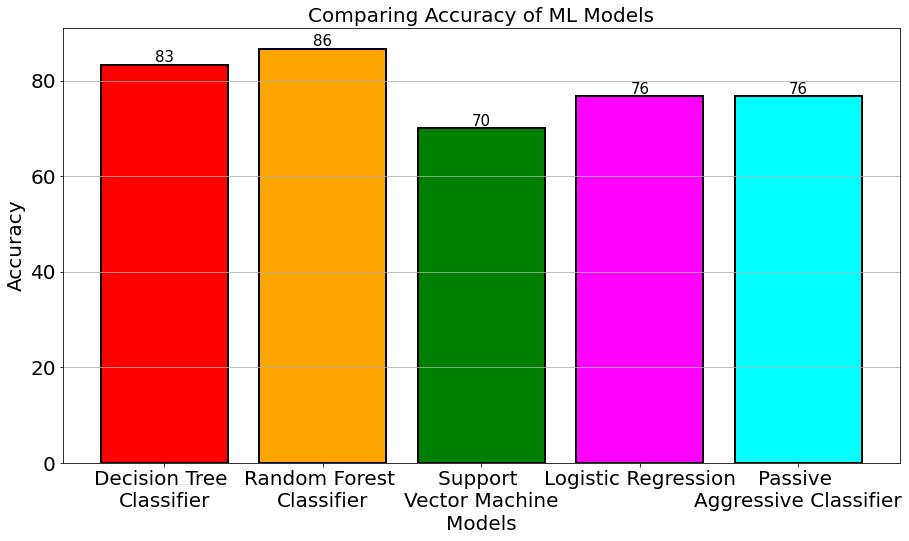

In [ ]:
accuracy_scores = [accuracy_dtc, accuracy_rfc, accuracy_svc, accuracy_lr, accuracy_pac]
model_names = ['Decision Tree \nClassifier', 'Random Forest \nClassifier', 'Support \nVector Machine',
               'Logistic Regression', 'Passive \nAggressive Classifier']

plt.figure(figsize=(15,8))

plt.grid(b=True, which='major', axis='y')
plt.title('Comparing Accuracy of ML Models',fontsize=20)
colors=['red','orange','green','magenta','cyan']
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.xlabel('Models',fontsize=20)
bar = plt.bar(model_names,accuracy_scores,edgecolor='black',color=colors, linewidth=2)
def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2, 1.0*(h), '%d'%int(h),
                    ha='center', va='bottom',fontsize=15)
autolabel(bar)

From the above bar we can see that the Random Forest Classifier is the best fitted model with highest accuracy among all the models.


In [ ]:
# Classification Report for Random Forest Classifier
predictions=model2.predict(np.hstack((vect.transform(test_df['Articles']).todense(),test_df.drop(['Label','Articles'], axis = 1))))
print(classification_report(test_df['Label'], predictions))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85        12
           1       0.94      0.83      0.88        18

    accuracy                           0.87        30
   macro avg       0.86      0.88      0.86        30
weighted avg       0.88      0.87      0.87        30



In [ ]:
print('Confusion Matrix for Random Forest Classifier')
cm=confusion_matrix(test_df['Label'],predictions)
print(cm)

Confusion Matrix for Random Forest Classifier
[[11  1]
 [ 3 15]]


In [ ]:
from IPython.display import clear_output
import ipywidgets as widgets
button_12 = widgets.Button(description="Last 12 months", style= {'button_color':'cyan'})
button_6 = widgets.Button(description="Last 6 months", style= {'button_color':'cyan'})
button_3 = widgets.Button(description="Last 3 months", style= {'button_color':'cyan'})

output = widgets.Output()
def on_button_clicked_12(b):
    with output:
        clear_output()
        plt.figure(figsize=(20,10))
        plt.title('Price movements in last 12 months', fontsize = 30)
        plt.plot(merge['Date'],merge['Label'], linewidth = 3)
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.show()
        
def on_button_clicked_6(b):
    with output:
        clear_output()
        plt.figure(figsize=(20,10))
        plt.title('Price movements in last 6 months', fontsize = 30)
        x = merge[merge['Date'] > '2020-06']
        plt.plot(x['Date'],x['Label'], linewidth = 3)
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.show()
        
def on_button_clicked_3(b):
    with output:
        clear_output()
        plt.figure(figsize=(20,10))
        plt.title('Price movements in last 3 months', fontsize = 30)
        x = merge[merge['Date'] > '2020-09']
        plt.plot(x['Date'],x['Label'], linewidth = 3)
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.show()
button_12.on_click(on_button_clicked_12)
button_6.on_click(on_button_clicked_6)
button_3.on_click(on_button_clicked_3)
buttons = widgets.HBox([button_12,button_6,button_3])
widgets.VBox([buttons,output])

# Stock Price Prediction

### Importing Libraries 

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense, GRU
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error, r2_score
tf.random.set_seed(1234)

### Loading and splitting the data into train and test data

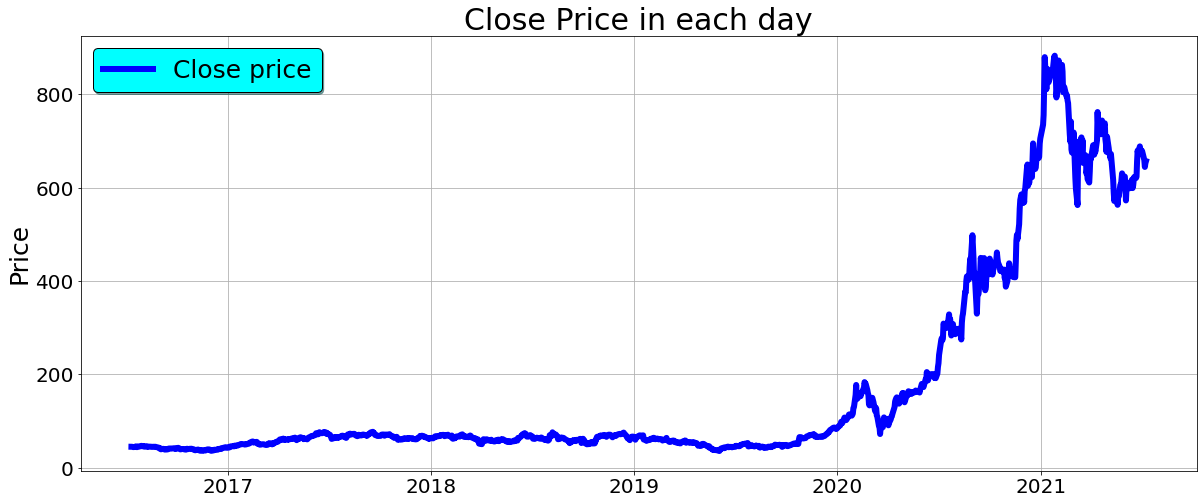

In [ ]:
stock = pd.read_csv('TSLA.csv') # Reading the csv file for stock prices
stock['Date'] = pd.to_datetime(stock['Date'])# convert date column to datetime
# Visualizing the price on each day
plt.figure(figsize = (20,8))
plt.grid(b=True, which='major', axis='both')
plt.title('Close Price in each day', fontsize = 30)
plt.plot(stock['Date'], stock['Close'], color='blue', label='Close price', linewidth=6)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Price', fontsize = 25)
plt.legend(fontsize=25,shadow=True,facecolor='cyan', edgecolor = 'k')
plt.show()

stock = stock[['Date', 'Close']] # filter the dataset to only date and close column
stock_train = stock[stock['Date'] < '2021'] # Store the data before 2021 in train data
stock_train.set_index('Date', inplace = True) # setting the date column as index
stock_test = stock[stock['Date'] > '2021'] # Store the data after 2021 in test data
stock_test.set_index('Date', inplace = True) # setting the date column as index

### Normalizing the datasets

In [ ]:
scaler = StandardScaler()
stock_train['Close'] = scaler.fit_transform(stock_train)
stock_test['Close'] = scaler.transform(stock_test)

### Data Windowing 

In [ ]:
window_size = 60
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(window_size, len(stock_train)):
    X_train.append(stock_train.iloc[i-window_size:i].values) 
    y_train.append(stock_train.iloc[i, -1]) # consider Close as target
# Change them to numpy array
X_train, y_train = np.array(X_train), np.array(y_train).reshape(-1,1)

In [ ]:
# Concatenate train data to test data
dataset_total = np.concatenate((stock_train, stock_test), axis = 0)
# Split test data and last window-size of train data
inputs = dataset_total[len(dataset_total) - len(stock_test) - window_size:]
# Do the same thing for test data
X_test = []
y_test = []
for i in range(window_size, window_size+len(stock_test)):
    X_test.append(inputs[i-window_size:i, :]) 
    y_test.append(inputs[i, -1]) # consider Close as target
# Change them to numpy array
X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1, 1)

### Model Fitting and Training 

In [ ]:
model = Sequential()
# Input layer 
model.add(GRU (128, return_sequences = True, 
             input_shape = [X_train.shape[1], X_train.shape[2]]))
# Hidden layer
model.add(GRU(64))  
model.add(Dense(units = 1)) 
#Compile model
adamopt = Adam(lr=0.001)
model.compile(optimizer=adamopt, loss='mse')
model_history = model.fit(X_train, y_train, epochs = 100, batch_size = 100, validation_data = (X_test,y_test))

Epoch 1/100
11/11 [==============================] - 6s 245ms/step - loss: 0.2612 - val_loss: 0.2270
Epoch 2/100
11/11 [==============================] - 2s 170ms/step - loss: 0.0281 - val_loss: 1.4689
Epoch 3/100
11/11 [==============================] - 2s 175ms/step - loss: 0.0214 - val_loss: 0.3485
Epoch 4/100
11/11 [==============================] - 2s 173ms/step - loss: 0.0138 - val_loss: 0.4261
Epoch 5/100
11/11 [==============================] - 2s 174ms/step - loss: 0.0103 - val_loss: 0.2982
Epoch 6/100
11/11 [==============================] - 2s 168ms/step - loss: 0.0088 - val_loss: 0.2336
Epoch 7/100
11/11 [==============================] - 2s 167ms/step - loss: 0.0081 - val_loss: 0.2088
Epoch 8/100
11/11 [==============================] - 2s 171ms/step - loss: 0.0071 - val_loss: 0.1424
Epoch 9/100
11/11 [==============================] - 2s 170ms/step - loss: 0.0066 - val_loss: 0.1577
Epoch 10/100
11/11 [==============================] - 2s 170ms/step - loss: 0.0065 - val_lo

### Accuracy

In [ ]:
test_predict=regressor.predict(X_test)
accuracy = round(r2_score(y_test, test_predict)*100,2)
print('Accuracy of GRU model : {}'.format(accuracy))

Accuracy of GRU model : 89.27


### Visualizing the result

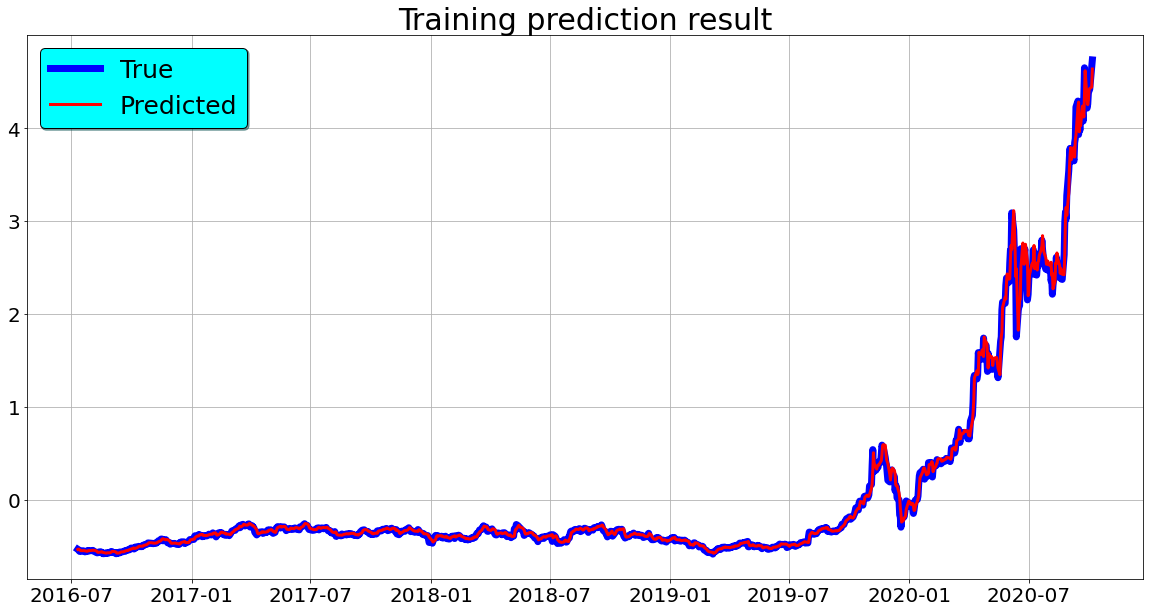

In [ ]:
train_predict=regressor.predict(X_train)
plt.figure(figsize = (20,10))
plt.grid(b=True, which='major', axis='both')
plt.title('Training prediction result', fontsize = 30)
plt.plot(stock_train.index[:1069], y_train,linewidth = 7, label='True', color = 'blue')
plt.plot(stock_train.index[:1069], train_predict,linewidth = 3,color = 'red', label='Predicted')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize=25,shadow=True,facecolor='cyan', edgecolor = 'k')
plt.show()

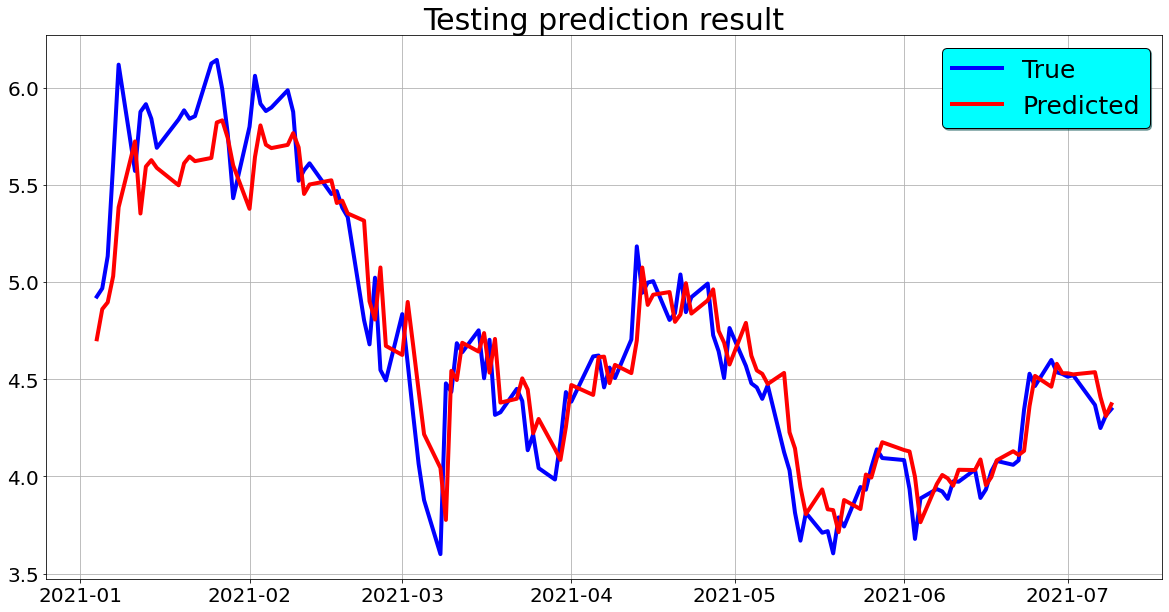

In [ ]:
plt.figure(figsize = (20,10))
plt.grid(b=True, which='major', axis='both')
plt.title('Testing prediction result', fontsize = 30)
plt.plot(stock_test.index, y_test,linewidth = 4, label='True', color = 'blue')
plt.plot(stock_test.index, test_predict,linewidth = 4,color = 'red', label='Predicted')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize=25,shadow=True,facecolor='cyan', edgecolor = 'k')
plt.show()

### Forecasting 

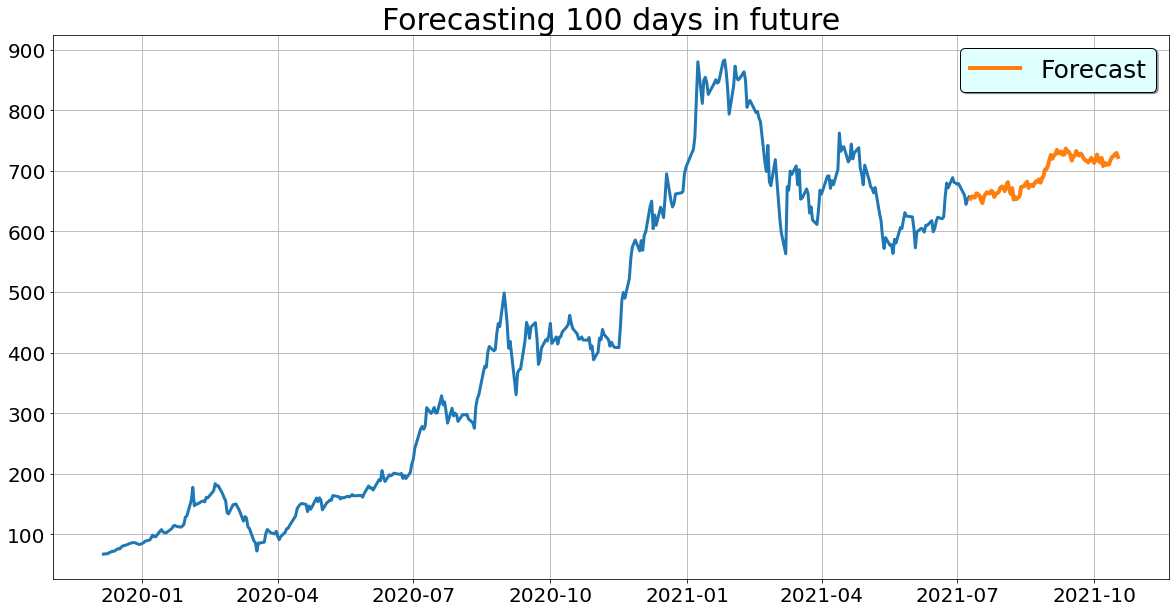

In [ ]:
model=sm.tsa.statespace.SARIMAX(stock['Close'],order=(1, 1, 1),seasonal_order=(1,1,1,60))
results=model.fit()
# creating future dates from 10 july to 100 plus days
forecast_dates=pd.date_range(start='07/10/2021', periods=100, freq='D') 
forecast=pd.DataFrame(forecast_dates,columns=['Date']) # creating data with dates as column
forecast['Date']=pd.to_datetime(forecast['Date']) # convert date to datetime
stock.set_index('Date', inplace = True)
forecast.set_index('Date',inplace=True)
result_df=pd.concat([stock,forecast]) # concatenating the two dataframes
dates = result_df.index # storing dataframe index as dates 
result_df.reset_index(inplace = True)
result_df.drop('Date', axis = 1, inplace = True)
# forecasting for 100 days 
result_df['forecast'] = results.predict(start = 1259,end = 1359, dynamic= True)
result_df['Date'] = dates
plt.figure(figsize = (20,10))
plt.grid(b=True, which='major', axis='both')
plt.title('Forecasting 100 days in future', fontsize = 30)
plt.plot(result_df['Date'][-500:], result_df['Close'][-500:], linewidth = 3 )
plt.plot(result_df['Date'][-1259:], result_df['forecast'][-1259:], linewidth = 4, label = 'Forecast')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize=25,shadow=True,facecolor='lightcyan', edgecolor = 'k')
plt.show()